In [1]:
from scipy.integrate import ode
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
from sklearn.preprocessing import MinMaxScaler
from time import time
from os import path

In [2]:
def lorenz(t, y, params):
    """
    Diferencialne enacbe Lorentzovega modela
    y = [x,y,z]
    dy = [dx/dt, dy/dt, dz/dt]
    params=[sigma,rho,beta]
    """
    dy=np.zeros(3)
    dy[0]=params[0]*(y[1]-y[0])
    dy[1]=(params[1]-y[2])*y[0] - y[1]
    dy[2]=y[0]*y[1] - params[2]*y[2]
    return dy

### Integracija Lorenzovega sistema v času ###

# definiarmo vrenosti parametrov params=[sigma,rho,beta]
params = [10., 28.,8./3.]

#nastavimo zacetni cas na 0
t = 0.
#dolzina casovnega koraka
dt=0.01

#koncni cas integracije
tmax=10000.

#Dolocimo vrednosti spremenljivk x,y, ob casu 0;
#nakljucne vrednosti so zrebane po enakomerni porazdelitvi
y0_ATM = np.array([np.random.uniform(-20,20),np.random.uniform(-20,20),np.random.uniform(10,30)])

# nasa njboljsa ocena trenutnega stanja ozracja ima napako
c=0.2
y0_MOD=y0_ATM + c*np.random.random(3)

#nastavimo integrator
solver_ATM=ode(lorenz).set_integrator('dopri5')
solver_ATM.set_f_params(params)
solver_ATM.set_initial_value(y0_ATM, t)

solver_MOD=ode(lorenz).set_integrator('dopri5')
solver_MOD.set_f_params(params)
solver_MOD.set_initial_value(y0_ATM, t)

In [3]:
if(path.exists("data/data-2.npy") != 1):
    print("Generating data.")
    n = int(tmax/dt) + 1
    data = np.zeros((n, 3))

    i = 0
    start = time()
    while t < tmax:
        y_ATM = solver_ATM.integrate(t+dt)
        #y0_MOD = solver_MOD.integrate(t+dt)
        data[i, :] = y_ATM[:]
        i = i + 1
        t += dt
    print("Elasped time: %0.3g s" %(time()-start))
    data = data[1000:] # only use data from the attractor (after time = 10000 * dt)
    print("Integration finished.")
    np.save("data/data-2.npy", data)
    
else:
    print("Data exist.")
    data = np.load("data/data-2.npy")
    print("Data loaded.")

Generating data.
Elasped time: 24.8 s
Integration finished.


In [4]:
#PREPROCESS DATA
x_train = data[:-1,:]
y_train = data[1:, :] - data[:-1, :]

x_scaler=MinMaxScaler()
y_scaler=MinMaxScaler()

x_scaler.fit(x_train)
y_scaler.fit(y_train)

x_train_norm=x_scaler.transform(x_train)
y_train_norm=y_scaler.transform(y_train)

xy_train_norm=np.concatenate((x_train_norm,y_train_norm), axis=1)

new_order=np.random.choice(range(x_train.shape[0]),x_train.shape[0],replace=False)
x_train_norm=x_train_norm[new_order]
y_train_norm=y_train_norm[new_order]

In [5]:
from tensorflow.keras.layers import Dense, Dropout
# create a "Sequential" model and add a Dense layer as the first layer
# ce nasa Loss ne vec pade se ustavi minimizacija
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')

#initializer = 
#ce dosezemo plato zmanjsamo korak ucenja
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model = tf.keras.models.Sequential()
model.add(Dense(3, input_dim=3, activation='relu'))
model.add(Dense(81, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(81, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(81, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(81, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='mean_absolute_error', optimizer='Adam', metrics=['mae'])

In [6]:
# Train model on data
start=time()
history = model.fit(x_train_norm, y_train_norm, epochs=200, batch_size=1024,validation_split=0.2,
                    callbacks=[callback,reduce_lr])
print("Elasped time: %0.3g s" %(time()-start))
print(model.summary())

Epoch 1/200
781/781 [==============================] - 3s 3ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0099 - val_mae: 0.0099
Epoch 2/200
781/781 [==============================] - 2s 3ms/step - loss: 0.0094 - mae: 0.0094 - val_loss: 0.0086 - val_mae: 0.0086
Epoch 3/200
781/781 [==============================] - 2s 3ms/step - loss: 0.0081 - mae: 0.0081 - val_loss: 0.0078 - val_mae: 0.0078
Epoch 4/200
781/781 [==============================] - 3s 3ms/step - loss: 0.0072 - mae: 0.0072 - val_loss: 0.0071 - val_mae: 0.0071
Epoch 5/200
781/781 [==============================] - 3s 3ms/step - loss: 0.0067 - mae: 0.0067 - val_loss: 0.0062 - val_mae: 0.0062
Epoch 6/200
781/781 [==============================] - 2s 3ms/step - loss: 0.0063 - mae: 0.0063 - val_loss: 0.0063 - val_mae: 0.0063
Epoch 7/200
781/781 [==============================] - 2s 3ms/step - loss: 0.0059 - mae: 0.0059 - val_loss: 0.0056 - val_mae: 0.0056
Epoch 8/200
781/781 [==============================] - 2s 3ms/step - 

781/781 [==============================] - 3s 3ms/step - loss: 0.0042 - mae: 0.0042 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 63/200
781/781 [==============================] - 3s 3ms/step - loss: 0.0042 - mae: 0.0042 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 64/200
781/781 [==============================] - 3s 3ms/step - loss: 0.0042 - mae: 0.0042 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 65/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0042 - mae: 0.0042 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 66/200
781/781 [==============================] - 3s 3ms/step - loss: 0.0042 - mae: 0.0042 - val_loss: 0.0042 - val_mae: 0.0042
Epoch 67/200
781/781 [==============================] - 3s 3ms/step - loss: 0.0042 - mae: 0.0042 - val_loss: 0.0042 - val_mae: 0.0042
Epoch 68/200
781/781 [==============================] - 3s 3ms/step - loss: 0.0042 - mae: 0.0042 - val_loss: 0.0042 - val_mae: 0.0042
Epoch 69/200
781/781 [==============================] - 3s 3ms/step - loss:

781/781 [==============================] - 3s 4ms/step - loss: 0.0040 - mae: 0.0040 - val_loss: 0.0040 - val_mae: 0.0040
Epoch 124/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0040 - mae: 0.0040 - val_loss: 0.0040 - val_mae: 0.0040
Epoch 125/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0040 - mae: 0.0040 - val_loss: 0.0040 - val_mae: 0.0040
Epoch 126/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0040 - mae: 0.0040 - val_loss: 0.0040 - val_mae: 0.0040
Epoch 127/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0040 - mae: 0.0040 - val_loss: 0.0040 - val_mae: 0.0040
Epoch 128/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0040 - mae: 0.0040 - val_loss: 0.0040 - val_mae: 0.0040
Epoch 129/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0040 - mae: 0.0040 - val_loss: 0.0040 - val_mae: 0.0040
Epoch 130/200
781/781 [==============================] - 3s 4ms/step 

Epoch 184/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0038 - mae: 0.0038 - val_loss: 0.0038 - val_mae: 0.0038
Epoch 185/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0038 - mae: 0.0038 - val_loss: 0.0038 - val_mae: 0.0038
Epoch 186/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0038 - mae: 0.0038 - val_loss: 0.0038 - val_mae: 0.0038
Epoch 187/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0038 - mae: 0.0038 - val_loss: 0.0038 - val_mae: 0.0038
Epoch 188/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0038 - mae: 0.0038 - val_loss: 0.0038 - val_mae: 0.0038
Epoch 189/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0038 - mae: 0.0038 - val_loss: 0.0038 - val_mae: 0.0038
Epoch 190/200
781/781 [==============================] - 3s 4ms/step - loss: 0.0038 - mae: 0.0038 - val_loss: 0.0038 - val_mae: 0.0038
Epoch 191/200
781/781 [==============================] 

In [7]:
from utils import moving_average

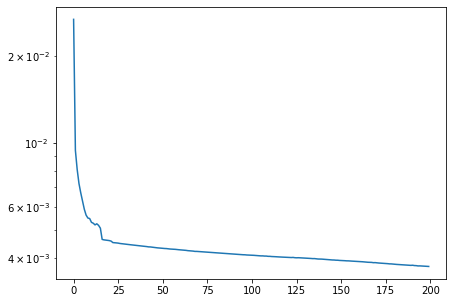

In [8]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'])
plt.yscale('log')

In [9]:
# Integriramo
tmax = 10
n = int(tmax/dt)+1
data_lorenz_NN = np.zeros((n,3))
data_lorenz_IN = np.zeros((n,3))

# define new IC
t=0
i=0

#izberemo zacetni pogoj nekje na atraktorju
y0=data[int(np.random.uniform(1000,data.shape[0]))]

#definiramo parametre Lorenzovega modela
params = [10., 28., 8./3.]

# definiramo ODE solver
solver_ATM = ode(lorenz).set_integrator('dopri5')
solver_ATM.set_f_params(params)
solver_ATM.set_initial_value(y0_ATM, t)
solver_ATM.set_initial_value(y0, t)

data_lorenz_IN[0, :]= y0
data_lorenz_NN[0, :]= y0

i=1
t=dt

print("Calculating...")
start = time()
while t < tmax:      
    y_ATM = solver_ATM.integrate(t+dt)
    data_lorenz_IN[i,:] = y_ATM[:]
    
    norm_input=x_scaler.transform(np.array([data_lorenz_NN[i-1,:]]))
    norm_output=model.predict(norm_input)
    
    add=y_scaler.inverse_transform(norm_output)
    data_lorenz_NN[i,:]=add[0] + data_lorenz_NN[i-1,:]
    
    i = i + 1
    t = t+dt
print("Finished in %.3g" %(time()-start))

Calculating...
Finished in 28.1


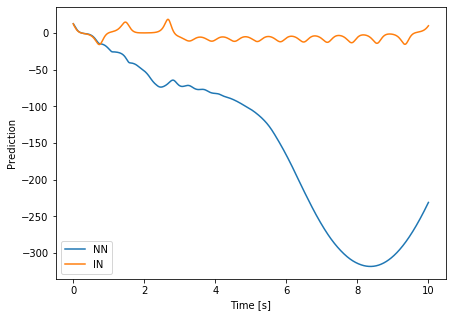

In [10]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(0, tmax+dt,dt), data_lorenz_NN[:,0], label='NN')
plt.plot(np.arange(0, tmax+dt,dt), data_lorenz_IN[:,0], label='IN')
plt.legend()
plt.ylabel("Prediction")
plt.xlabel("Time [s]")
plt.show()

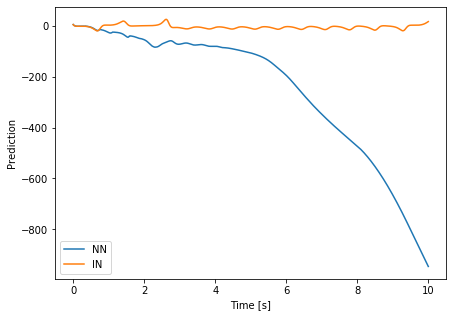

In [11]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(0, tmax+dt,dt), data_lorenz_NN[:,1], label='NN')
plt.plot(np.arange(0, tmax+dt,dt), data_lorenz_IN[:,1], label='IN')
plt.legend()
plt.ylabel("Prediction")
plt.xlabel("Time [s]")
plt.show()

In [12]:

# Compute moving average
def moving_average(a, n=3) :
    
    idx = np.cumsum(np.arange(len(a)),dtype=float)
    idx[n:] = idx[n:] - idx[:-n]
    
    res = np.cumsum(a, dtype=float)
    res[n:] = res[n:] - res[:-n]
    
    return idx[n - 1:] / n, res[n - 1:] / n


In [13]:
"""plt.figure(figsize=(7.5, 4.5))
plt.plot(history.history['loss'], label='train',alpha=0.2)
plt.plot(moving_average(history.history['loss'], 40)[1], label='train, ma=40')
plt.plot(history.history['val_loss'], label='val')
plt.plot(moving_average(history.history['val_loss'], 40)[1], label='val, ma=40')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#plt.ylim([0, 0.005])
plt.yscale('log')
plt.show()"""

"plt.figure(figsize=(7.5, 4.5))\nplt.plot(history.history['loss'], label='train',alpha=0.2)\nplt.plot(moving_average(history.history['loss'], 40)[1], label='train, ma=40')\nplt.plot(history.history['val_loss'], label='val')\nplt.plot(moving_average(history.history['val_loss'], 40)[1], label='val, ma=40')\nplt.xlabel('epoch')\nplt.ylabel('Loss')\nplt.legend()\nplt.tight_layout()\n#plt.ylim([0, 0.005])\nplt.yscale('log')\nplt.show()"